In [19]:
# Import Libraries

import os
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
import spacy

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [20]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


# Load Spacy model for lemmatization
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# Load datasets

# Folder path containing the CSV files

path = kagglehub.dataset_download("bahushruth/legalclausedataset")
print("Path to dataset files:", path)

# List all CSV files in the folder
csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]

# Read all CSVs into a list of DataFrames
dataframes = [pd.read_csv(os.path.join(path, file)) for file in csv_files]

# Combine all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Print the result
print(f"Loaded {len(df)} CSV files.")
print("Combined DataFrame shape:", df.shape)

print(df.head())

Path to dataset files: /root/.cache/kagglehub/datasets/bahushruth/legalclausedataset/versions/1
Loaded 150881 CSV files.
Combined DataFrame shape: (150881, 2)
                                         clause_text clause_type
0  PREAMBLE. The licenses for most software are d...    preamble
1  PREAMBLE. LMC SERPs . . . . . . . . . . . . . ...    preamble
2  PREAMBLE. The licenses for most software are d...    preamble
3  PREAMBLE. The board of directors of Southwest ...    preamble
4  PREAMBLE. The parties agree that this article ...    preamble


In [23]:
# Undersand the dataset
print(df)
print(df['clause_type'].value_counts().sort_index())

                                              clause_text clause_type
0       PREAMBLE. The licenses for most software are d...    preamble
1       PREAMBLE. LMC SERPs . . . . . . . . . . . . . ...    preamble
2       PREAMBLE. The licenses for most software are d...    preamble
3       PREAMBLE. The board of directors of Southwest ...    preamble
4       PREAMBLE. The parties agree that this article ...    preamble
...                                                   ...         ...
150876  Access. (a) Seller will authorize and permit C...      access
150877  Access. (a) Prior to the Closing Date, Seller ...      access
150878  Access. Seller acknowledges that to enable Pur...      access
150879  Access. At any time whilst an Event of Default...      access
150880  Access. During any period in which the Seller ...      access

[150881 rows x 2 columns]
clause_type
absence-of-certain-changes              350
absence-of-certain-changes-or-events    350
acceleration                     

In [24]:
# Remove blanks
df.dropna(inplace=True)
print(df)

                                              clause_text clause_type
0       PREAMBLE. The licenses for most software are d...    preamble
1       PREAMBLE. LMC SERPs . . . . . . . . . . . . . ...    preamble
2       PREAMBLE. The licenses for most software are d...    preamble
3       PREAMBLE. The board of directors of Southwest ...    preamble
4       PREAMBLE. The parties agree that this article ...    preamble
...                                                   ...         ...
150876  Access. (a) Seller will authorize and permit C...      access
150877  Access. (a) Prior to the Closing Date, Seller ...      access
150878  Access. Seller acknowledges that to enable Pur...      access
150879  Access. At any time whilst an Event of Default...      access
150880  Access. During any period in which the Seller ...      access

[150881 rows x 2 columns]


In [25]:
# Preprocessing functions
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatization
    doc = nlp(" ".join(tokens))
    lemmatized = [token.lemma_ for token in doc]
    return " ".join(lemmatized)

In [26]:
# Reducing Dataset to improve processing speed
df = df.sample(frac=0.05)
df

# Apply preprocessing
df['processed_text'] = df['clause_text'].apply(preprocess_text)
print(df)

                                              clause_text         clause_type  \
112508  Officers. The officers of the Bank may include...            officers   
8924    Support. This Agreement does not include techn...             support   
148829  Amendments, Etc. The terms of this Agreement m...      amendments-etc   
31092   Assignability. This Agreement shall not be ass...       assignability   
39669   Benefits. An incoming employee is subject to t...            benefits   
...                                                   ...                 ...   
142668  Term of Employment. This Agreement shall comme...  term-of-employment   
39527   NON-DISCRIMINATION. The provisions of this Agr...  non-discrimination   
56006   Amendments. This Agreement shall not be change...          amendments   
96823   Warranties. Each Party's warranties in this Ag...          warranties   
89200   Costs. Except as otherwise provided in this Ag...               costs   

                           

In [27]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)

In [28]:
X = vectorizer.fit_transform(df['processed_text']).toarray()
y = df['clause_type']

In [29]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Define classifiers and hyperparameters
classifiers = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
        },
    },
    "SVC": {
        "model": SVC(random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"],
        },
    },
    "MultinomialNB": {
        "model": MultinomialNB(),
        "params": {
            "alpha": [0.5, 1.0, 2.0],
        },
    },
}

In [31]:
# Perform GridSearchCV for each classifier and collect results
results = []

for clf_name, clf_info in classifiers.items():
    grid = GridSearchCV(clf_info["model"], clf_info["params"], scoring="accuracy", cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Best estimator evaluation
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Store results
    results.append({
        "Classifier": clf_name,
        "Best Parameters": grid.best_params_,
        "Accuracy": acc,
    })

# Create a summary table
results_df = pd.DataFrame(results)
print(tabulate(results_df, headers="keys", tablefmt="grid"))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


+----+---------------+------------------------------------------------------------------+------------+
|    | Classifier    | Best Parameters                                                  |   Accuracy |
+====+===============+==================================================================+============+
|  0 | RandomForest  | {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} |   0.612989 |
+----+---------------+------------------------------------------------------------------+------------+
|  1 | SVC           | {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}                  |   0.638834 |
+----+---------------+------------------------------------------------------------------+------------+
|  2 | MultinomialNB | {'alpha': 0.5}                                                   |   0.463883 |
+----+---------------+------------------------------------------------------------------+------------+


In [32]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4638833664678595
Classification Report:
                                                precision    recall  f1-score   support

                   absence-of-certain-changes       0.50      1.00      0.67         5
         absence-of-certain-changes-or-events       0.00      0.00      0.00         3
                                 acceleration       0.00      0.00      0.00         4
                                       access       0.00      0.00      0.00         2
                             accounting-terms       1.00      1.00      1.00         8
                        additional-agreements       0.67      0.50      0.57         8
                         additional-documents       0.00      0.00      0.00         3
                                  adjustments       1.00      0.40      0.57         5
                        affirmative-covenants       0.83      0.56      0.67         9
                                    agreement       0.00      0.00      0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [40]:
# Example inference: Extract obligations from a new clause
def extract_and_classify_clause(clause):
    processed_clause = preprocess_text(clause)
    vectorized_clause = vectorizer.transform([processed_clause]).toarray()
    predicted_label = best_model.predict(vectorized_clause)
    return predicted_label[0]

In [41]:
# Example clause for testing
example_clause = "The supplier must deliver the goods within 30 days of receiving the purchase order."
predicted_label = extract_and_classify_clause(example_clause)
print(f"Predicted Label: {predicted_label}")

Predicted Label: good-reason


In [39]:
# Visualizations


# Visualize distribution of labels
def visualize_label_distribution(data):
    plt.figure(figsize=(12, 8))
    sns.countplot(x='clause_type', data=data, order=data['clause_type'].value_counts().index, palette='viridis')
    plt.title('Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()                           # Adjust layout to avoid clipping
    plt.show()

# Visualize most common words
def visualize_common_words(data, column='processed_text', n=20):
    from collections import Counter
    all_words = " ".join(data[column]).split()
    common_words = Counter(all_words).most_common(n)

    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=words, palette='coolwarm')
    plt.title('Most Common Words in Processed Text')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.show()



# Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Visualize feature importance (for Random Forest)
def plot_feature_importance(classifier, vectorizer):
    feature_names = vectorizer.get_feature_names_out()
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align="center", color="skyblue")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title("Top 20 Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

<ipython-input-44-fd1a8c71a158>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='clause_type', data=data, order=data['clause_type'].value_counts().index, palette='viridis')


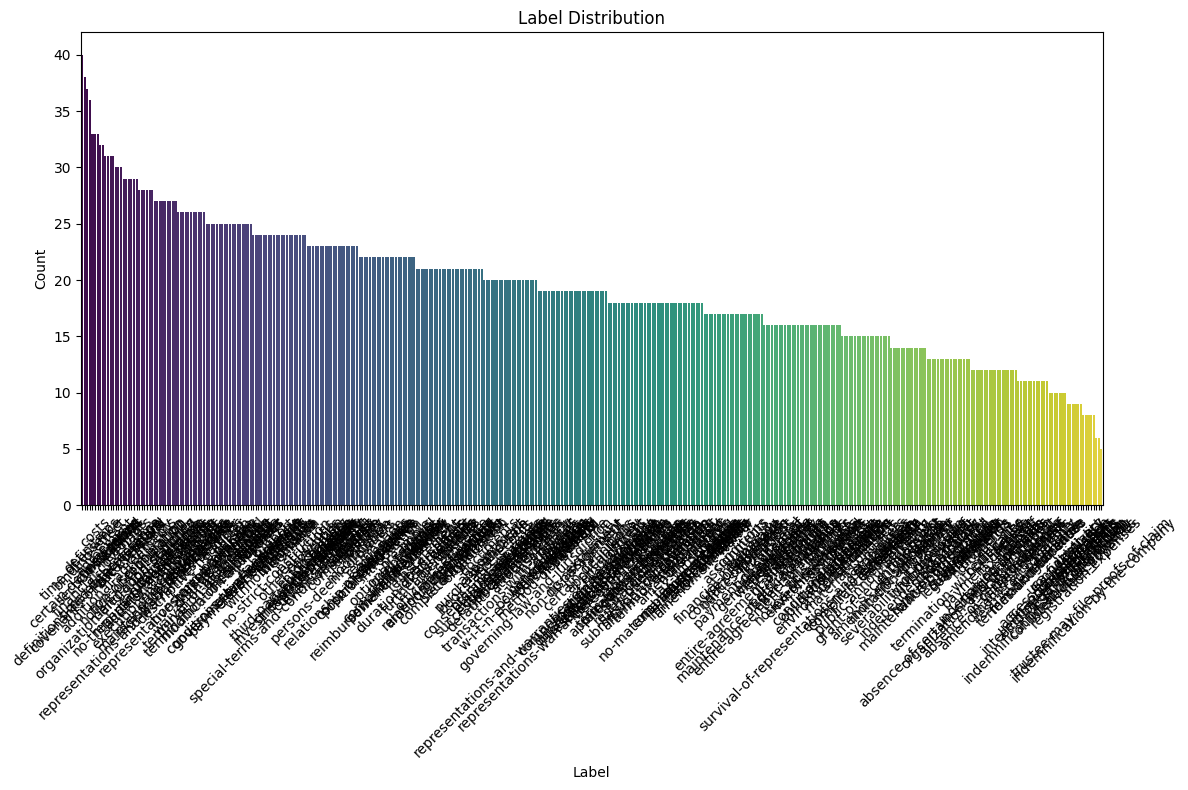

<ipython-input-44-fd1a8c71a158>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='coolwarm')


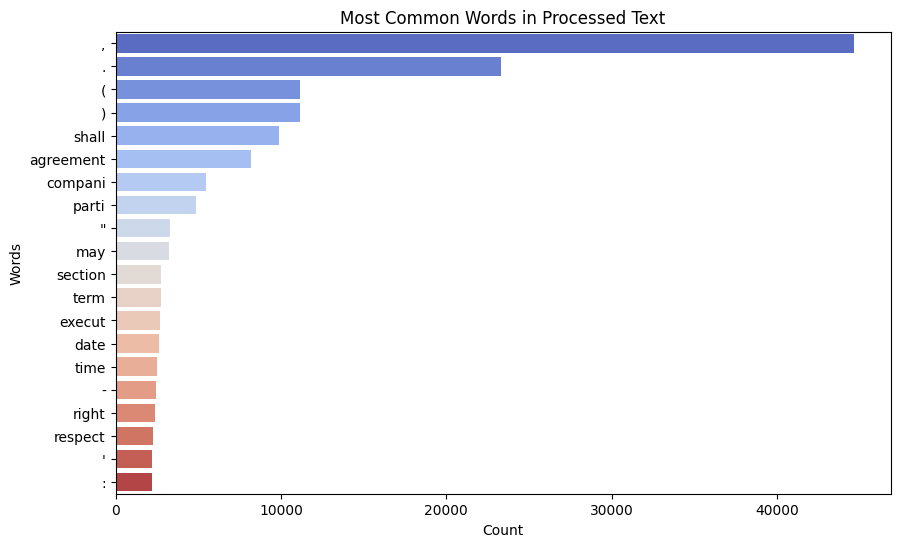

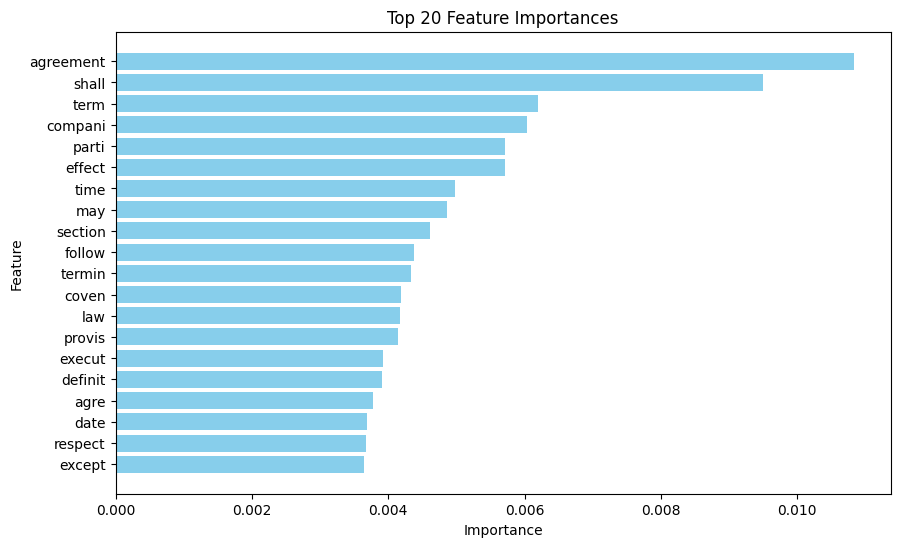

In [ ]:
# Call visualization functions
visualize_label_distribution(df)
visualize_common_words(df)

# After predictions
plot_feature_importance(classifier, vectorizer)